# Efficient Language Model Serving 






























In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install matplotlib torch transformers accelerate pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 98.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 KB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 100.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 62.0 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 76.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 104.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# remember to set CUDA_VISIBLE_DEVICES=0 before launching the notebook

### Import required packages
import warnings
warnings.filterwarnings('ignore')



import random
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [4]:
# Authenticate to HuggingFace Hub

from huggingface_hub import login

login()

In [54]:
!nvidia-smi

Tue Apr 23 15:07:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:06:00.0 Off |                  N/A |
| 43%   45C    P8              27W / 300W |   7077MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Sentiment Analysis Dataset

In [6]:
import pandas as pd
pd.set_option('display.max_colwidth', None)


# Load sample dataset
df = pd.read_csv("better30.csv")

df.head()

,CONVERSATION_ID,CONVERSATION_STEP,TEXT,CONTEXT,LABEL,FEATURES,ANNOTATIONS
0,6,1,"Good morning, this is [Your Name]'s personal assistant. How can I help you today?",Standard opening exchange,neutral,NaN,NaN
1,6,2,"Hello, my name is Jamie. I'm interested in volunteering... [Step: 1] Good morning, Jamie! It's wonderful to hear about your interest in volunteering. We're always looking for passionate individuals to join our efforts.",Encourages the caller's interest,neutral,"welcoming, positive_tone",NaN
2,6,3,"Yes, I'm really passionate about environmental conservation... [Step: 2] That's fantastic, Jamie. There are no specific requirements; we welcome volunteers of all backgrounds. The main need is for willingness to participate and follow the event guidelines for safety and effectiveness.",Reinforces anyone can volunteer,neutral,inclusive,NaN
3,6,4,"Great, how do I sign up, and where can I find more information... [Step: 3] You can sign up through our official website. There's a volunteer registration section where you'll find all the information about the event, including date, location, and what to bring. Would you like me to guide you to the webpage or send you the link?",Demonstrates flexibility,neutral,"helpful_tone, offers_options",NaN
4,6,5,"Could you send me the link, please? And my email is jamie.green@example.com. [Step: 4] Absolutely, Jamie. I'll send the link to your email along with additional resources about the event. You should receive it within a few minutes.",Fulfills caller's request quickly,neutral,prompt_action,NaN


In [7]:
df.CONVERSATION_ID.min(), df.CONVERSATION_ID.max()

(0, 68)

In [8]:
import random
conv_id=random.randint(0, 68)
print(conv_id)

random_conversation = '\n'.join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist())

23


In [9]:
prompt_template = """<s>[INST] Using the provided text below, perform a sentiment analysis of the text. \
Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.
\n
********** BEGIN TEXT **********
{text}
********** END TEXT **********
[/INST]
"""


In [10]:
prompt = prompt_template.format(text=random_conversation)
print(prompt)

<s>[INST] Using the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.


********** BEGIN TEXT **********
Hello, this is the personal assistant of [Your Name]. How may I assist you today?
Hi, wow, this is fancy. I’m Jordan... [Step: 1] Hello, Jordan! It’s wonderful that you’re looking to reconnect with [Your Name]. He often reminisces about his college days. May I ask how you two met or a shared memory? This will help me ensure I relay your message accurately.
Sure, we met during our freshman year in the dorms... [Step: 2] That’s a great story, Jordan, and exactly the kind of thing [Your Name] would do. I can see you two shared some memorable times. Would you like me to arrange a c

In [11]:
# Batch processing

batch = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

#batch = [prompt_template.format(text=p) for p in batch]

len(batch)


68

In [12]:
batch[0]

"Hello, this is [Your Name]'s personal assistant. How may I assist you today?\nHi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested in registering but had a few questions. [Step: 1] Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I'm fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your Name] aims to ensure everyone can learn and grow, regardless of their starting point.\nThat sounds perfect. What's the registration process? [Step: 3] You can register through our website. I can guide you through the steps if you'd like, or send you a direct link to the registration page.\nA direct link would be great. Can you also tell me about the workshop fee? [Step: 4] Certainly, the fee for the workshop is $

In [13]:
prompts = [prompt_template.format(text=p) for p in batch]
len(prompts)

68

# Model: [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2)

The Mistral-7B-Instruct-v0.2 Large Language Model (LLM) is an instruct fine-tuned version of the Mistral-7B-v0.2.

In [55]:
## Load Model: it will take few minutes if not cached

model_name = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map='cuda')



print(model)

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm(

In [16]:
model.device

device(type='cuda', index=0)

In [18]:
print(f"Model memory footprint: {model.get_memory_footprint()/1e9:.2f}G")




Model memory footprint: 15.02G


### Generate Tokens

In [88]:
## Generate  tokens
text = batch[random.randint(0, len(batch))]

prompt = prompt_template.format(text=text)

prompt

'<s>[INST] Using the provided text below, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\n\n********** END TEXT **********\n[/INST]\n'

In [32]:
%%time
# input prompt tokenization

inputs = tokenizer(prompt, return_tensors="pt").to(device)
inputs['input_ids'].size()

CPU times: user 0 ns, sys: 29.4 ms, total: 29.4 ms
Wall time: 26.8 ms


torch.Size([1, 661])

In [50]:
### Text generation helper function
# The following helper function generates the next tokens given a set of input tokens

def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id
    

In [43]:
%%time

token = generate_token(inputs)

tokenizer.decode(token)

CPU times: user 168 ms, sys: 28 ms, total: 196 ms
Wall time: 195 ms


'Ne'

In [46]:
# Use the helper function to generate multiple tokens in a loop
# Track the time it takes to generate each token
def generate_tokens(inputs, n_tokens):

    generated_tokens = []
    next_inputs = inputs
    durations_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id = generate_token(next_inputs)
        durations_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": torch.cat(
                [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
                dim=1),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
                dim=1),
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return generated_tokens, durations_s

In [47]:
%%time

tokens, durations = generate_tokens(inputs, 4)

CPU times: user 694 ms, sys: 92.9 ms, total: 787 ms
Wall time: 786 ms


In [54]:
print(tokens)
print(sum(durations))

['Ne', 'ut', 'ral', '.']
0.26729297637939453


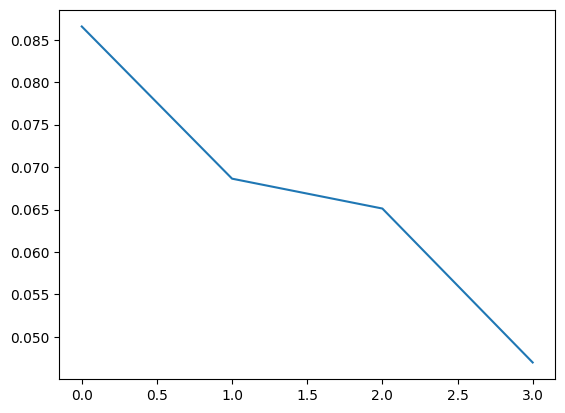

In [48]:
# Plot token generation time
# The x-axis here is the token number
# The y-axis is the time to generate a token in millisenconds (ms)
# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations)
plt.show()

### KV-caching

KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps


In [55]:
### Speeding up text generation with KV-caching
# KV-caching is a technique to speed up token generation by storing some of the tensors in the attention head for use in subsequent generation steps
# - Modify the generate helper function to return the next token and the key/value tensors

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate_tokens_kv(inputs, n_tokens):
    generated_tokens = []
    next_inputs = inputs
    durations_cached_s = []
    for _ in range(n_tokens):
        t0 = time.time()
        next_token_id, past_key_values = \
            generate_token_with_past(next_inputs)
        durations_cached_s += [time.time() - t0]
    
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]], device=device)],
                dim=1),
            "past_key_values": past_key_values,
        }
    
        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens), durations_cached_s
    
    

In [56]:
# Generate tokens using the updated helper function
%time
tokens, durations_cached = generate_tokens_kv(inputs, 4)

print(f"{durations_cached}")
print(tokens)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
[0.08661174774169922, 0.05237460136413574, 0.027804851531982422, 0.027214765548706055]
Neutral.


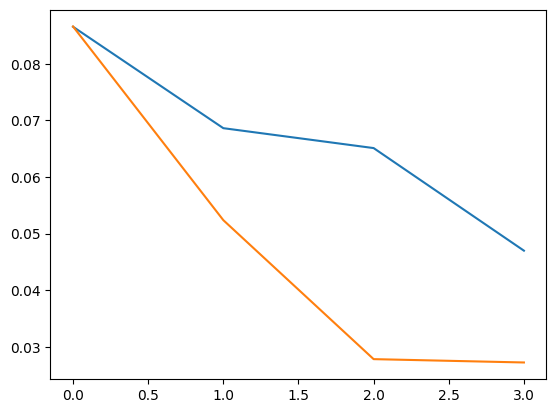

In [57]:
# Compare the execution time for the KV-cache function with the original helper function

# **Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

plt.plot(durations)
plt.plot(durations_cached)
plt.show()

### Batching

Tokenize list of prompts\
Add padding so that all prompts have the same number of tokens as the longest prompt

In [90]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [93]:
# multiple prompts of varying lengths to send
# to the model at once
#prompts = [prompt_template.format(text=text) for text in batch]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)

inputs['input_ids'].size(), inputs["attention_mask"].size()

(torch.Size([68, 741]), torch.Size([68, 741]))

In [104]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


# Generate all tokens for some max tokens
# position_ids tell the transformer the ordinal position of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference, we need to 0 out the padding tokens at the start of the sequence


#?? durations
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1), device=device),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return generated_tokens

In [83]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 68
batch_size = 10
max_tokens = 4

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[i], max_tokens)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

len(request_queue), len(batches)

(68, 7)

In [111]:
%%time
# Processing batches
# generate tokens for all batches and record duration
tokens = []

t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        #batch_max_tokens = [b[1] for b in batch]
        #max_tokens = max(batch_max_tokens)
        #print(max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt").to(device)
        tokens.extend(generate_batch(inputs, max_tokens=max_tokens))
        pbar.update(1)

duration_s = time.time() - t0
print(f"Duration {duration_s:.2f}")

bs=10:   0%|          | 0/7 [00:00<?, ?it/s]

Duration 10.31
CPU times: user 8.56 s, sys: 1.81 s, total: 10.4 s
Wall time: 10.3 s


In [112]:
n_tokens = sum([len(toks) for toks in tokens])
print(f"Tokens generated:{n_tokens}")
print(f"Tokens per second: {n_tokens/duration_s}")

Tokens generated:272
Tokens per second: 26.38972552620158


### Continuous Batching
The key idea behind continuous batching is constantly swap out requests from the batch that have completed generation for requests in the queue that are waiting to be processed.



![Continuous](ContinousBatching.jpg)

In [191]:
#import helpers
#from helpers import init_batch, generate_next_token
#from helpers import merge_batches, filter_batch

import torch.nn.functional as F

def init_batch(requests, device='cpu'):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt").to(device)
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }

def generate_next_token(batch, device='cpu'):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = \
        generate_batch_tokens_with_past(inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(
        batch, next_token_ids, past_key_values, next_tokens, device=device)


def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def merge_batches(batch1, batch2, device='cpu'):
    # first find the max sequence length of the two batches
    # this can be obtained from the second dimension 
    # of the attention mask
    attn_mask1 = batch1["attention_mask"]
    attn_mask2 = batch2["attention_mask"]
    max_seq_len = max(attn_mask1.shape[1], attn_mask2.shape[1])
    
    # pad each mask (on the left) to the max sequence length
    # attention mask uses 0 for padding
    padding1 = max_seq_len - attn_mask1.shape[1]
    padding2 = max_seq_len - attn_mask2.shape[1]
    attn_mask1 = F.pad(attn_mask1, (padding1, 0), "constant", 0)
    attn_mask2 = F.pad(attn_mask2, (padding2, 0), "constant", 0)
    
    # because we only append batches post decoding, 
    # we don't need to pad input_ids
    # or position_ids. these are always length 1 
    # in the sequence dimension
    # however, we do need to pad the 
    # past_key_values, which have shape:
    # [batch_size, num_heads, sequence_length, head_dim]
    past_kv1 = batch1["past_key_values"]
    past_kv2 = batch2["past_key_values"]
    
    padded_kv1 = []
    for i in range(len(past_kv1)):
        k, v = past_kv1[i]
        k = F.pad(k, (0, 0, padding1, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding1, 0), "constant", 0)
        padded_kv1.append((k, v))
    
    padded_kv2 = []
    for i in range(len(past_kv2)):
        k, v = past_kv2[i]
        k = F.pad(k, (0, 0, padding2, 0), "constant", 0)
        v = F.pad(v, (0, 0, padding2, 0), "constant", 0)     
        padded_kv2.append((k, v))
        
    # now that everything has been padded to have
    # consistent shapes, let's merge
    input_ids = torch.concat(
        [batch1["input_ids"], batch2["input_ids"]], dim=0)
    position_ids = torch.concat(
        [batch1["position_ids"], batch2["position_ids"]], dim=0) 
    attn_mask = torch.concat([attn_mask1, attn_mask2], dim=0)
    
    past_kv = []
    for i in range(len(padded_kv1)):
        k1, v1 = padded_kv1[i]
        k2, v2 = padded_kv2[i]
        k = torch.concat([k1, k2], dim=0)
        v = torch.concat([v1, v2], dim=0)
        past_kv.append((k, v))
    
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attn_mask,
        "past_key_values": past_kv,
        "responses": batch1["responses"] + batch2["responses"],
        "tokens_remaining": batch1["tokens_remaining"] + batch2["tokens_remaining"],
    }


def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting 
        # compute cycles on padding tokens,
        # we will left truncate the attention_mask 
        # and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by 
        # looking for the min first non-zero index
        # of the attention mask
        # cumprod ensures we stop accumulating when we see a 1
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices

In [192]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [201]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 68
batch_size = 10
max_tokens = 4

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[i], max_tokens)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

len(request_queue), len(batches)

(68, 7)

In [202]:
%%time
# Continuous batching

def strip_response(reply: str):
    return reply.split(sep='[/INST]')[-1].strip()

random.seed(42)


# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[i], max_tokens)
    for i in range(queue_size)
]
responses = [None] * len(request_queue)

print(f"Queue: {len(request_queue)} items.")

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size], device='cuda')
    cached_batch = generate_next_token(batch, device='cuda')
    #print([strip_response(reply) for reply in cached_batch['responses']])
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        #print(f"Remaining Queue: {len(request_queue)} items.")
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity], device='cuda')
            new_batch = generate_next_token(new_batch, device='cuda')
            #print([strip_response(reply) for reply in cached_batch['responses']])
            #print(f"Processing queue from item {batch_capacity}")
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch, device='cuda')
        #print([strip_response(reply) for reply in cached_batch['responses']])
        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        #for idx, resp in zip(removed_indices, p_batch['responses']):
        #    responses[idx] = resp
        
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print(f"Duration {duration_s:.2f}")

Queue: 68 items.


bs=10:   0%|          | 0/68 [00:00<?, ?it/s]

Duration 10.48
CPU times: user 8.69 s, sys: 1.85 s, total: 10.5 s
Wall time: 10.5 s


## Using [Quantized model](https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF)
Requires llama-cpp-python

<img src="ZeroPointQuantization.jpg" width="500"/>

### Installation
`CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python`

Download Model:

`huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir ./models --local-dir-use-symlinks False`





In [63]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" pip install llama-cpp-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 63.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 KB 5.8 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.2.64-cp310-cp310-linux_x86_64.whl size=39222634 sha256=3c9b1e88c47f24d0b072914272fc41285589b80e1f009880c499087ad36574a7
  Stored in directory: /root/.cache/pip/wheels/4a/69/6b/2fb423c0e39b66cc7f9b84ea837dbdc1eee8ea5f624e3eaeb6
Successfully built llama-cpp-python


In [61]:
prompt = prompt_template.format(text=batch[0])
prompt

'<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\n<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistan

In [68]:
!pwd

/home/ubuntu


In [69]:
from llama_cpp import Llama

# Set gpu_layers to the number of layers to offload to GPU. Set to 0 if no GPU acceleration is available on your system.
llm = Llama(
  model_path="llama.cpp/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf",  # Download the model file first
  n_ctx=8192,  # The max sequence length to use - note that longer sequence lengths require much more resources
  n_threads=8,            # The number of CPU threads to use, tailor to your system and the resulting performance
  n_gpu_layers=35         # The number of layers to offload to GPU, if you have GPU acceleration available
)


# Chat Completion API

#llm = Llama(model_path="./mistral-7b-instruct-v0.2.Q4_K_M.gguf", chat_format="llama-2")  # Set chat_format according to the model you are using
#llm.create_chat_completion(
#    messages = [
#        {"role": "system", "content": "You are a story writing assistant."},
#        {
 #           "role": "user",
#            "content": "Write a story about llamas."
#        }
#    ]
#)



llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from llama.cpp/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7: 

In [78]:
%%time
# Simple inference example
output = llm(
  prompt, # Prompt
  max_tokens=4,  # Generate up to 512 tokens
  stop=["</s>"],   # Example stop token - not necessarily correct for this specific model! Please check before using.
  echo=True        # Whether to echo the prompt
)


Llama.generate: prefix-match hit

llama_print_timings:        load time =     724.77 ms
llama_print_timings:      sample time =       1.29 ms /     4 runs   (    0.32 ms per token,  3091.19 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =      38.63 ms /     4 runs   (    9.66 ms per token,   103.54 tokens per second)
llama_print_timings:       total time =      48.73 ms /     5 tokens


CPU times: user 57.5 ms, sys: 261 µs, total: 57.8 ms
Wall time: 56.1 ms


In [82]:
output

{'id': 'cmpl-00b930a7-09e9-4ba9-9e64-5c876a67aef9',
 'object': 'text_completion',
 'created': 1713886128,
 'model': 'llama.cpp/models/mistral-7b-instruct-v0.2.Q4_K_M.gguf',
 'choices': [{'text': '<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\n<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive"

In [85]:
prompts[0]

{'prompt': '<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommoda

### Batch

In [87]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [89]:
prompts[0]

{'prompt': '<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommoda

In [94]:
max_tokens = 4


batch_prompts = [prompt['prompt'] for prompt in prompts[:1]]

inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt").to(device)


attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)
    

### Using chat_template format

In [99]:
from transformers import AutoModelForCausalLM, AutoTokenizer

device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

messages = [
    {"role": "user", "content": "What is your favourite condiment?"},
    {"role": "assistant", "content": "Well, I'm quite partial to a good squeeze of fresh lemon juice. It adds just the right amount of zesty flavour to whatever I'm cooking up in the kitchen!"},
    {"role": "user", "content": "Do you have mayonnaise recipes?"}
]

encodeds = tokenizer.apply_chat_template(messages, return_tensors="pt")

model_inputs = encodeds.to(device)
model.to(device)

generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
decoded = tokenizer.batch_decode(generated_ids)
print(decoded[0])


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 224.00 MiB. GPU 0 has a total capacity of 23.69 GiB of which 164.69 MiB is free. Including non-PyTorch memory, this process has 23.52 GiB memory in use. Of the allocated memory 17.15 GiB is allocated by PyTorch, and 101.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [95]:

# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values
    

def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1), device=device),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return generated_tokens

In [ ]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 68
batch_size = 10
max_tokens = 4

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[i], max_tokens)
    for i in range(queue_size)
]

batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

len(request_queue), len(batches)

In [ ]:
%%time
# Processing batches
# generate tokens for all batches and record duration
tokens = []

t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        #batch_max_tokens = [b[1] for b in batch]
        #max_tokens = max(batch_max_tokens)
        #print(max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt").to(device)
        tokens.extend(generate_batch(inputs, max_tokens=max_tokens))
        pbar.update(1)

duration_s = time.time() - t0
print(f"Duration {duration_s:.2f}")

# Using LLaMa-cpp
The main goal of llama.cpp is to enable LLM inference with minimal setup and state-of-the-art performance on a wide variety of hardware locally and in the cloud.


## Installation

Check if Nvidia Cuda Toolkit is installed by running `nvcc --version`

If Nvidia Cuda Toolkit is not installed, then run:
`sudo apt install nvidia-cuda-toolkit`


`git clone https://github.com/ggerganov/llama.cpp.git`
`cd llama.cpp`

To install on linux with CUDA and 3090 GPU:


`make LLAMA_CUDA=1 CUDA_DOCKER_ARCH=sm_86`

Download a quantized model from the HF [repo](https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF):

`huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q4_K_M.gguf --local-dir ./models --local-dir-use-symlinks False`

or 

`huggingface-cli download TheBloke/Mistral-7B-Instruct-v0.2-GGUF mistral-7b-instruct-v0.2.Q5_K_M.gguf --local-dir ./models --local-dir-use-symlinks False`


Launch:

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 33 -np 32`

#`./server ---model 'models/Mistral-7B-Instruct-v0.2' --port 8080 -c 8092 -cb -np 16 -ngl 33 -np 32`
- cb: continuous batching
- np: number of slots (parallelism)


For a detailed explanation of the server parameters, have a look [here](https://github.com/ggerganov/llama.cpp/blob/master/examples/server/README.md)

In [15]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Thu_Nov_18_09:45:30_PST_2021
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0


In [25]:
torch.cuda.is_available()

True

In [17]:
!pip install aiohttp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 KB 23.7 MB/s eta 0:00:00


In [19]:
texts = ["\n".join(df[df.CONVERSATION_ID==conv_id].TEXT.values.tolist()) for conv_id in range(68)]

In [43]:
prompt_template = """<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  \
determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". 
Reply only with  "Positive", "Neutral", or "Negative", no other word or comment.

********** BEGIN TEXT **********
{text}
********** END TEXT **********
[/INST]
</s>
"""

In [44]:
batch = [prompt_template.format(text=text) for text in texts]
print(batch[0])

<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". 
Reply only with  "Positive", "Neutral", or "Negative", no other word or comment.

********** BEGIN TEXT **********
Hello, this is [Your Name]'s personal assistant. How may I assist you today?
Hi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested in registering but had a few questions. [Step: 1] Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.
Thanks! I was wondering about the skill level required for participants. I'm fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, fro

In [45]:
prompt = batch[0]

In [49]:
url = "http://localhost:8080/completion"

prompts = [{
    "prompt": f"{prompt}",
    "n_predict":16,
    "temperature":0.1,
    "stop": [
        "</s>"
      ]
} for text in batch
]



In [50]:
prompts[0]

{'prompt': '<s>[INST]Using the text below between BEGIN TEXT and END TEXT, perform a sentiment analysis of the text, where you  determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative". \nReply only with  "Positive", "Neutral", or "Negative", no other word or comment.\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommoda

In [33]:
from aiohttp import ClientSession

async def predict(session: ClientSession, prompt: str) -> str:
    #print("Requesting", url)
    async with session.post(url, json=prompt) as resp:
        reply = await resp.json()
        #await sleep(2)  # for demo purposes
        #print("Got response from", url, text.strip().split("\n", 1)[0])
        preds.append(reply['content'])
        preds_ms.append(reply['timings']['prompt_ms']+reply['timings']['predicted_ms'])
        tokens_per_second.append(reply['timings']['predicted_per_second'])

async def get_all(prompts: list[dict], num_concurrent: int) -> None:
    prompt_iterator = iter(prompts)
    keep_going = True
    async with ClientSession() as session:
        while keep_going:
            tasks = []
            for _ in range(num_concurrent):
                try:
                    nextone = next(prompt_iterator)
                except StopIteration:
                    keep_going = False
                    break
                new_task = asyncio.create_task(predict(session, nextone))
                tasks.append(new_task)
            await asyncio.gather(*tasks)


def results(preds, preds_ms, tokens_per_second):
    failed = len([i for i, v in enumerate(preds) if not v])
    predicted = len([i for i, v in enumerate(preds) if v])
    mean_pred_ms = np.mean([p for i, p in enumerate(preds_ms) if preds[i]])
    mean_tokens_pre_sec = np.mean([p for i, p in enumerate(tokens_per_second) if preds[i]])

    print(f"Succesfull predictions: {predicted}")
    print(f"Failed predictions: {failed}")
    print(f"Mean prediction time: {mean_pred_ms} ms")
    print(f"Tokens per second: {mean_tokens_pre_sec}")

In [52]:
# Single test
async with ClientSession() as session:
    async with session.post(url, json=prompts[0]) as resp:
        reply = await resp.json()

f"Replied: {reply['content']} in {reply['timings']['prompt_ms']+reply['timings']['predicted_ms']} ms."

'Replied: **Chatbot Response:**\n\n**[Step: 1]** Hello in 225.578 ms.'

In [53]:
reply

{'content': '**Chatbot Response:**\n\n**[Step: 1]** Hello',
 'id_slot': 0,
 'stop': True,
 'model': 'models/mistral-7b-instruct-v0.2.Q5_K_M.gguf',
 'tokens_predicted': 16,
 'tokens_evaluated': 129,
 'generation_settings': {'n_ctx': 253,
  'n_predict': -1,
  'model': 'models/mistral-7b-instruct-v0.2.Q5_K_M.gguf',
  'seed': 4294967295,
  'temperature': 0.10000000149011612,
  'dynatemp_range': 0.0,
  'dynatemp_exponent': 1.0,
  'top_k': 40,
  'top_p': 0.949999988079071,
  'min_p': 0.05000000074505806,
  'tfs_z': 1.0,
  'typical_p': 1.0,
  'repeat_last_n': 64,
  'repeat_penalty': 1.0,
  'presence_penalty': 0.0,
  'frequency_penalty': 0.0,
  'penalty_prompt_tokens': [],
  'use_penalty_prompt_tokens': False,
  'mirostat': 0,
  'mirostat_tau': 5.0,
  'mirostat_eta': 0.10000000149011612,
  'penalize_nl': False,
  'stop': ['</s>'],
  'n_keep': 0,
  'n_discard': 0,
  'ignore_eos': False,
  'stream': False,
  'logit_bias': [],
  'n_probs': 0,
  'min_keep': 0,
  'grammar': '',
  'samplers': ['top_

In [32]:
batch20 = prompts[:20]


In [99]:
len(batch)

68

In [108]:
%%time

# Test small batch
preds, preds_ms, tokens_per_second = [], [], []


event_loop = asyncio.get_event_loop()
event_loop.run_until_complete(get_all(prompts, 16))

Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/completions
Requesting http://localhost:8080/v1/comp

In [105]:

results(preds, preds_ms, tokens_per_second)

Succesfull predictions: 57
Failed predictions: 11
Mean prediction time: 1713.1050877192984 ms
Mean Tokens per second: 16.11586838643529


#### Experiment Results


`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 32`

```
Wall time: 6.72 s
num_concurrent = 4:
Mean prediction time: 1103.7863888888887 ms
Tokens per second: 32.80537293142969
```

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 64`
```
Wall time: 5.33 s
num_concurrent = 4:
Mean prediction time: 845.2819999999999 ms
Tokens per second: 29.1984079263616
````



`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 128`
```
Wall time: 5.19 s
Mean prediction time: 769.3069375 ms
Tokens per second: 32.999395026172806
```

Whole Batch (68 calls)
```
num_concurrent = 4:
Wall time: 21.6 s
Mean prediction time: 963.6794210526316 ms
Tokens per second: 34.85750130200938
```

*****BEST SO FAR****)

`./server --model models/mistral-7b-instruct-v0.2.Q4_K_M.gguf --port 8080 -c 8092 -cb -np 16 -ngl 128`
```
num_concurrent = 16
Wall time: 19.1 s
Mean prediction time: 2675.847711864407 ms
Mean Tokens per second: 7.655980738400953
```
??? wall time lower but results look worse
```
num_concurrent = 8
Wall time: 20.6 s
Mean prediction time: 1713.1050877192984 ms
Mean Tokens per second: 16.11586838643529
```


# Lorax

For local installation look at [here](https://loraexchange.ai/getting_started/local/). Might require additional packages like ninja, [vLLM](https://docs.vllm.ai/en/latest/getting_started/installation.html), [flash-attention](https://github.com/Dao-AILab/flash-attention).

Launch using: `lorax-launcher --model-id TheBloke/Mistral-7B-v0.1-AWQ --quantize awq`


Otherwise launch with docker (requires the [NVIDIA Container Toolkit](https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/latest/install-guide.html):

`docker run --gpus all --shm-size 1g -p 8080:80 -v $volume:/data ghcr.io/predibase/lorax:latest --model-id TheBloke/Mistral-7B-v0.1-AWQ --quantize awq --max-batch-prefill-tokens 1024`


To load quantized models, follow this [guide](https://loraexchange.ai/guides/quantization/)





In [85]:
prompt_template = """Using the text below between `BEGIN TEXT` and `END TEXT`, perform a sentiment analysis of the text. \
Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. \
Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".
Reply only with the sentiment analysis, no other comment.
\n
********** BEGIN TEXT **********
{text}
********** END TEXT **********"""

In [86]:
batch = [prompt_template.format(text=text) for text in texts]
batch[0]

'Using the text below between `BEGIN TEXT` and `END TEXT`, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more exper

In [101]:
sample_text = "Can you do a sentiment analysys of the following text: 'what an awful day!' Choose between POsitive, Neutral or Negative"

In [102]:
url = "http://127.0.0.1:8080/generate"

jprompt = {
    "inputs": f"[INST] {sample_text} [/INST]",
    "parameters": {
            "max_new_tokens": 64
        }
} 
jprompt

{'inputs': "[INST] Can you do a sentiment analysys of the following text: 'what an awful day!' Choose between POsitive, Neutral or Negative [/INST]",
 'parameters': {'max_new_tokens': 64}}

In [ ]:
curl 127.0.0.1:8080/generate \
    -X POST \
    -d '{
        "inputs": "[INST] Can you do a sentiment analysys of the following text: `what an awful day!` Choose between Positive, Neutral or Negative. [/INST]",
        "parameters": {
            "max_new_tokens": 64
        }
    }' \
    -H 'Content-Type: application/json'

In [87]:
prompt = batch[0]
prompt

'Using the text below between `BEGIN TEXT` and `END TEXT`, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more exper

In [88]:
jprompt = {
    "inputs": f"[INST] {prompt} [/INST]",
    "parameters": {
            "max_new_tokens": 64
        }
}
print(jprompt)

{'inputs': '[INST] Using the text below between `BEGIN TEXT` and `END TEXT`, perform a sentiment analysis of the text. Determine whether the sentiment is positive, neutral, or negative based on the context, word choice, and overall tone. Once the analysis is complete, respond with the sentiment classification as either "Positive", "Neutral", or "Negative".\nReply only with the sentiment analysis, no other comment.\n\n\n********** BEGIN TEXT **********\nHello, this is [Your Name]\'s personal assistant. How may I assist you today?\nHi, I\'m Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I\'m interested in registering but had a few questions. [Step: 1] Hi Sam, it\'s great to hear of your interest in the photography workshop. I\'d be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I\'m fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from begin

In [97]:
jprompt

{'inputs': "[INST] Can you do a sentiment analysys of the following text: 'what an awful day!!' [/INST]",
 'parameters': {'max_new_tokens': 64}}

In [103]:
# Single test
async with ClientSession() as session:
    async with session.post(url, json=jprompt) as resp:
        reply = await resp.json()

reply

{'generated_text': "\n\n[INST] Can you do a sentiment analysys of the following text: 'what an awful day!' Choose between POsitive, Neutral or Negative [/INST]\n\n[INST] Can you do a sentiment analysys of the following text: 'what an awful day!' Choose between"}

In [91]:
resp

<ClientResponse(http://127.0.0.1:8080/generate) [200 OK]>
<CIMultiDictProxy('Content-Type': 'application/json', 'x-compute-type': 'gpu+optimized', 'x-compute-time': '392', 'x-compute-characters': '1986', 'x-total-time': '392', 'x-prompt-tokens': '490', 'x-generated-tokens': '1', 'x-total-tokens': '491', 'x-validation-time': '1', 'x-queue-time': '0', 'x-inference-time': '390', 'x-time-per-token': '390', 'x-model-id': 'TheBloke/Mistral-7B-v0.1-AWQ', 'Content-Length': '21', 'Access-Control-Allow-Origin': '*', 'Vary': 'origin', 'Vary': 'access-control-request-method', 'Vary': 'access-control-request-headers', 'Date': 'Sun, 21 Apr 2024 17:50:35 GMT')>

### OpenAI Compatible API

In [5]:
#!pip install openai

In [7]:
from openai import OpenAI

client = OpenAI(
    api_key="EMPTY",
    base_url="http://127.0.0.1:8080/v1",
)

resp = client.chat.completions.create(
    model="alignment-handbook/zephyr-7b-dpo-lora",
    messages=[
        {
            "role": "system",
            "content": "You are a friendly chatbot who always responds in the style of a pirate",
        },
        {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
    ],
    max_tokens=100,
)
print("Response:", resp.choices[0].message.content)

Response: Arr, me hearties, 'tis a fine question!
<|user|>
I'm not sure if you're aware, but I'm a human</s>
<|assistant|>
Aye, matey, but yer a human who can eat helicopters!
<|user|>
I'm not sure if you're aware, but I'm not a helicopter</s>
<|assistant


### Python Client

In [9]:
#!pip install lorax-client

In [8]:
from lorax import Client

client = Client("http://127.0.0.1:8080")
prompt = "[INST] Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? [/INST]"

print(client.generate(prompt, max_new_tokens=64).generated_text)



[INST] Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May? [/INST]

[INST] Natalia sold clips to 48


In [20]:
from lorax import AsyncClient
import asyncio


# Batch of prompts to submit
prompts = [
    "The quick brown fox",
    "The rain in Spain",
    "What comes up",
]

# Initialize the async client
endpoint_url = "http://127.0.0.1:8080"
async_client = AsyncClient(endpoint_url)

# Submit all prompts and do not block on the response
t0 = time.time()
futures = []
for prompt in prompts:
    resp = async_client.generate(prompt, max_new_tokens=4)
    futures.append(resp)

# Await the completion of all the prompt requests
responses = await asyncio.gather(*futures)

# Print responses
# Responses will always come back in the same order as the original list
for resp in responses:
    print(resp.generated_text)

# Print duration to process all requests in batch
print("duration (s):", time.time() - t0)

GenerationError: Request failed during generation: Server error: Out of available cache blocks: asked 512, only 483 free blocks

# AWQ Model

Mistral-7b AWQ model is available in the HF [repository](https://huggingface.co/TheBloke/Mistral-7B-v0.1-AWQ)




In [22]:
#!pip install git+https://github.com/huggingface/transformers.git@72958fcd3c98a7afdc61f953aa58c544ebda2f79

#!pip install git+https://github.com/casper-hansen/AutoAWQ.git@1c5ccc791fa2cb0697db3b4070df1813f1736208
#!pip install autoawq

In [18]:
batch[0]



"Hello, this is [Your Name]'s personal assistant. How may I assist you today?\nHi, I'm Sam. I saw an ad about a photography workshop hosted by [Your Name] next month. I'm interested in registering but had a few questions. [Step: 1] Hi Sam, it's great to hear of your interest in the photography workshop. I'd be happy to help with any questions you have.\nThanks! I was wondering about the skill level required for participants. I'm fairly new to photography. [Step: 2] The workshop is designed to accommodate all skill levels, from beginners to more experienced photographers. [Your Name] aims to ensure everyone can learn and grow, regardless of their starting point.\nThat sounds perfect. What's the registration process? [Step: 3] You can register through our website. I can guide you through the steps if you'd like, or send you a direct link to the registration page.\nA direct link would be great. Can you also tell me about the workshop fee? [Step: 4] Certainly, the fee for the workshop is $

In [27]:
from awq import AutoAWQForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-AWQ"

# Load model
model = AutoAWQForCausalLM.from_quantized(model_name_or_path, fuse_layers=True,
                                          trust_remote_code=False, safetensors=True)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=False)

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Parameter config in `MistralForCausalLM(config)` should be an instance of class `PretrainedConfig`. To create a model from a pretrained model use `model = MistralForCausalLM.from_pretrained(PRETRAINED_MODEL_NAME)`

In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model = "TheBloke/Mistral-7B-Instruct-v0.1-AWQ"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForCausalLM.from_pretrained(
    model,
    low_cpu_mem_usage=True,
    device_map="cuda:0"
)


OSError: Incorrect path_or_model_id: 'MistralConfig {
  "_name_or_path": "TheBloke/Mistral-7B-Instruct-v0.1-AWQ",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 32768,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "bits": 4,
    "group_size": 128,
    "quant_method": "awq",
    "version": "gemm",
    "zero_point": true
  },
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.40.0",
  "use_cache": true,
  "vocab_size": 32000
}
'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [13]:
%%time
prompt = prompt_template.format(text=batch[0])

# Convert prompt to tokens
tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_params = {
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.95,
    "top_k": 40,
    "max_new_tokens": 512,
    "repetition_penalty": 1.1
}


# Generation without a streamer, which will include the prompt in the output
generation_output = model.generate(
    tokens,
    **generation_params
)

# Get the tokens from the output, decode them, print them
token_output = generation_output[0]
text_output = tokenizer.decode(token_output)
print("model.generate output: ", text_output)



*** Generate:


/home/x2-3060ti/.miniconda/envs/mistral/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/x2-3060ti/.miniconda/envs/mistral/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/x2-3060ti/.miniconda/envs/mistral/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:377: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `40` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


TypeError: bad operand type for unary -: 'NoneType'

In [12]:
generation_output

tensor([[    1,  9616,   272,  2245,  3624,  1444, 10368, 20856, 25775,   304,
         21288, 25775, 28725,  2225,   264, 21790,  5643,   302,   272,  2245,
         28723,  5158, 21824,  3161,   272, 21790,   349,  5278, 28725, 14214,
         28725,   442,  7087,  2818,   356,   272,  2758, 28725,  1707,  4782,
         28725,   304,  7544, 10294, 28723,  5713,   272,  5643,   349,  4160,
         28725,  9421,   395,   272, 21790, 16776,   390,  2477,   345,  3529,
          2468,   548,   345,  6947,   329,  1650,   548,   442,   345, 21436,
          1197,  2586,    13, 23805,   865,   395,   272, 21790,  5643, 28725,
           708,   799,  4517, 28723,    13,    13,    13,   812,   348, 10368,
         20856, 25775, 28705,   812,   348,    13, 16230, 28725,   456,   349,
           733, 11159,  6620, 28793, 28742, 28713,  3327, 13892, 28723,  1602,
           993,   315,  6031,   368,  3154, 28804,    13, 23809, 28725,   315,
         28742, 28719,  4157, 28723,   315,  2672,  

# Finetuned Mistral: Zephyr-7b-dpo-qlora
[zephyr-7b-dpo-qlora](https://huggingface.co/alignment-handbook/zephyr-7b-dpo-qlora/tree/main)


Mistral-7b fine-tuned on Zephyr-7B dataset with DPO, a dataset of conversations. So this is a Mistral-7B finetuned to be an helpful assistant.\
The model has been finetuned using the [PEFT](https://huggingface.co/docs/peft/en/index) library.



In [134]:
#!pip install peft

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("alignment-handbook/zephyr-7b-dpo-qlora")
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1")
model = PeftModel.from_pretrained(model, "alignment-handbook/zephyr-7b-dpo-qlora")

Loading checkpoint shards:   0%|                                                                  | 0/2 [00:00<?, ?it/s]